## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/SE.rds"
minCell = 10
top_de = 3
p_thresh = 0.1 
minPct = 0.01
logfcthresh = 0.1
outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/de_clone_btwncond_RNA/minPct0.01_logfc0.1_minCells10/" 
sample_names = "preB,postB"
#n_clones_to_plot = 15


# Parallel processing
cores = 4
# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"


# Parameters
assay="RNA"
test.use="wilcox"
latent.vars = "NULL"


In [2]:
source(utils_script)
source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")
dir.create(outdir, showWarnings = FALSE)

btwnConds_inClone_sepDonors.outdir <- outdir #file.path(outdir, "btwnConds_inClone_sepDonrs")
#dir.create(btwnConds_inClone_sepDonors.outdir)


Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in dir.create(btwnConds_inClone_sepDonors.outdir):
“'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/de_clone_btwncond_RNA/minPct0.01_logfc0.1_minCells10//btwnConds_inClone_sepDonrs' already exists”


In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "preB"  "postB"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")
library(dplyr)
library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package:

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
61893 features across 4112 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

# Get clones with mininum  cells in each condition and run DE pre and post

In [6]:
source(utils_script)
tmp = get.clone.sizes(se)
counts.norm=tmp[["counts.norm"]]
clone.sizes = tmp[["clone.size"]]
head(clone.sizes)

`summarise()` has grouped output by 'condition', 'donor', 'lineage'. You can override using the `.groups` argument.

Warning message in xtfrm.data.frame(x):
"cannot xtfrm data frames"
`summarise()` has grouped output by 'donor'. You can override using the `.groups` argument.



donor,lineage,norm.total,total,name,cdf.norm,cdf,index
<fct>,<fct>,<dbl>,<int>,<fct>,<dbl>,<int>,<int>
0,0,0.13254870,41,0_0,0.06627435,41,1
0,1,0.12483766,37,0_1,0.12869318,78,2
0,2,0.09269481,28,0_2,0.17504058,106,3
0,3,0.08254870,27,0_3,0.21631494,133,4
0,7,0.07905844,25,0_7,0.25584416,158,5
0,9,0.07775974,23,0_9,0.29472403,181,6


In [7]:
curr.counts.norm = counts.norm[counts.norm$size>minCell,]
tmp.thresh = curr.counts.norm %>% group_by(name) %>% mutate(size=n())
curr.counts.norm = curr.counts.norm[tmp.thresh$size > 1, ]
curr.counts.norm = curr.counts.norm[order(curr.counts.norm$name),]
topClones = unique(curr.counts.norm$name)
curr.counts.norm

condition,donor,lineage,name,size,total,norm
<fct>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>
preB,0,0,0_0,22,280,0.07857143
postB,0,0,0_0,19,352,0.05397727
postB,0,7,0_7,14,352,0.03977273
preB,0,7,0_7,11,280,0.03928571
preB,1,0,1_0,17,356,0.04775281
postB,1,0,1_0,13,305,0.04262295
preB,1,1,1_1,19,356,0.05337079
postB,1,1,1_1,11,305,0.03606557
postB,1,2,1_2,13,305,0.04262295


In [8]:
topClones

[1] 0_0 0_7 1_0 1_1 1_2 1_3
185 Levels: 0_0 0_1 0_10 0_11 0_12 0_13 0_14 0_15 0_16 0_17 0_18 0_19 ... None

Saving 6.67 x 6.67 in image



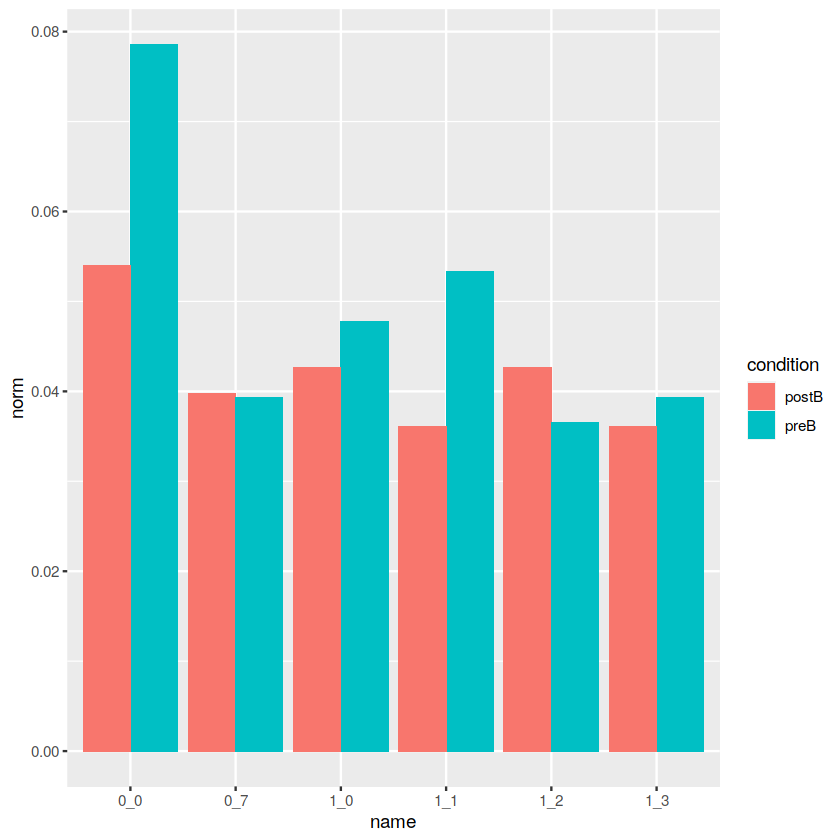

In [9]:
ggplot(data=curr.counts.norm, aes(x=name,y=norm, fill = condition)) + 
        geom_col(position='dodge') 
    

ggsave(file.path(outdir, "topClonesSize_NormBatch.pdf"))

Saving 6.67 x 6.67 in image



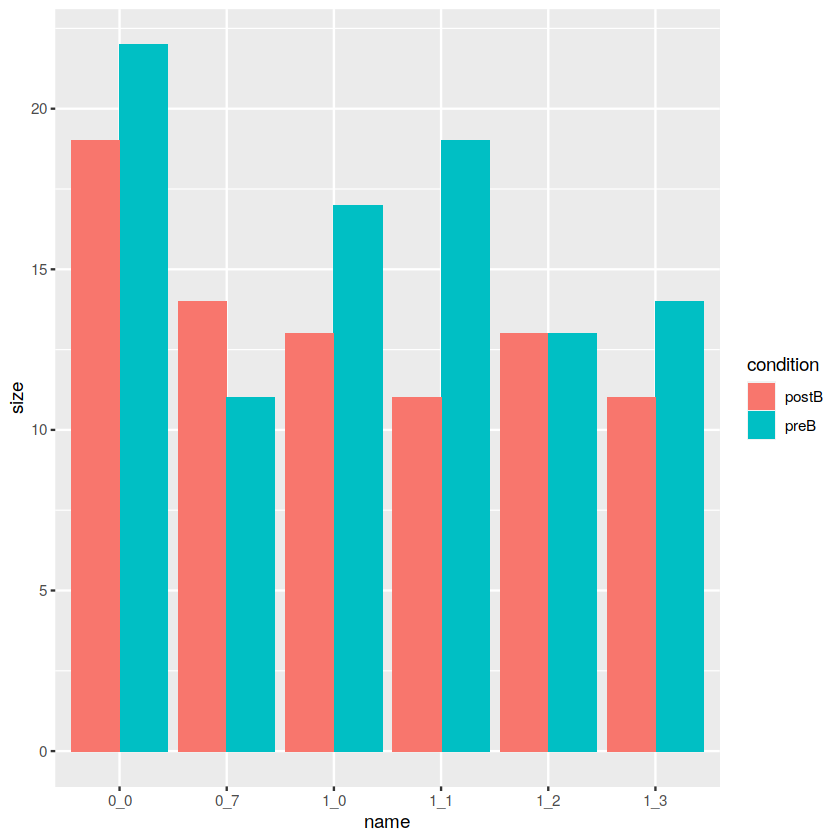

In [10]:
ggplot(data=curr.counts.norm, aes(x=name,y=size, fill = condition)) + 
        geom_col(position='dodge') 
    

ggsave(file.path(outdir, "topClonesSize.pdf"))

# Stimulus specific response in each clone
Loop through names and then run de btwn the conditions

In [11]:
all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()

#sample_names
clone.ids <- sort(unique(se$name))
se$clone.stim <- paste(se$name, se$orig.ident, sep = "_")

se$clone <- se$name
Idents(se) <- "clone.stim"

count = 1
for (curr.clone in topClones){  #} clone.ids ){
    ident.1 = paste0(curr.clone, "_", sample_names[[1]]) 
    ident.2 = paste0(curr.clone, "_", sample_names[[2]])
    try({
        print(curr.clone)
    
        ## Setup output and names
        tmp.counts <- curr.counts.norm[(curr.counts.norm$name==curr.clone), ]
        curr.count.a <- tmp.counts[tmp.counts$condition==sample_names[[1]], "size"]
        curr.count.b <- tmp.counts[tmp.counts$condition==sample_names[[2]], "size"]
        print('curr.count.a')
        print(curr.count.a)
        curr.name <-paste0("clone_", curr.clone)
        curr.dir <-paste0("clone_", curr.clone, "counts_", sample_names[[1]], curr.count.a,
                           "counts_", sample_names[[2]], curr.count.b)
        curr.clone.outdir <- file.path(btwnConds_inClone_sepDonors.outdir, paste(count,curr.dir,sep="_"))
        dir.create(curr.clone.outdir)

        ## Run DE
        curr.sig <- find.markers.and.plot(se, ident.1, ident.2, curr.clone.outdir, 
                                          curr.name=curr.clone, assay="RNA", logfcthresh=logfcthresh,
                                          min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
        # Add DE to global results
        names.sig <- rownames(curr.sig)
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        all.pvals[names.sig,curr.clone] <- curr.sig$p_val_adj_BH

        # Plot expression scatter 
        curr_clone <- subset(se, subset = name == curr.clone)
        avg_curr_clone <- data.frame(log1p(AverageExpression(curr_clone, verbose = FALSE)$RNA))
        avg_curr_clone$gene <- rownames(avg_curr_clone)
        p1 <- ggplot(avg_curr_clone, aes_string(paste0("X", curr.clone, "_", sample_names[[1]]), 
                                                paste0("X", curr.clone, "_", sample_names[[2]]))) + geom_point() + ggtitle(paste("Cluster", curr.clone))
        p1 <- LabelPoints(plot = p1, points = head(names.sig,3), repel = TRUE)
        plot_grid(p1)
        #write.csv(response, file=file.path(curr.clone.outdir,paste0("clone_",c,".conditionDE.csv")))
        ggsave(file.path(curr.clone.outdir,paste0(curr.name,".allDonors.conditionScatter.png")))
        
        })
    count = count + 1
    }
     



[1] "0_0"
[1] "curr.count.a"


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom



# A tibble: 1 × 1
   size
  <int>
1    22
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 41 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
TCF25  2.512671e-06  0.6542706 0.773 0.000 0.04918554   0.02054611
ARID5A 6.682782e-06  0.7525642 0.727 0.000 0.13081547   0.02732256
PAPD5  1.117779e-05  0.6123829 0.773 0.053 0.21880530   0.03046694
DNPEP  3.383943e-05  0.5460845 0.864 0.158 0.66240676   0.06820880
FAAP20 4.170771e-05  0.6108989 0.636 0.000 0.81642850   0.06820880
TMBIM6 9.338174e-05  0.5714326 0.864 0.211 1.00000000   0.08759239
[1] "dim response"
[1] 8177    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results

Saving 6.67 x 6.67 in image



[1] "0_7"
[1] "curr.count.a"
# A tibble: 1 × 1
   size
  <int>
1    11
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 25 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 9370    6
Error in LabelPoints(plot = p1, points = head(names.sig, 3), repel = TRUE) : 
  Cannot find points provided
[1] "1_0"
[1] "curr.count.a"
# A tibble: 1 × 1
   size
  <int>
1    17
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
61893 features across 30 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        

## DE sig summarize

In [12]:
all.names.sig

[1] "TCF25"  "ARID5A" "PAPD5"

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been

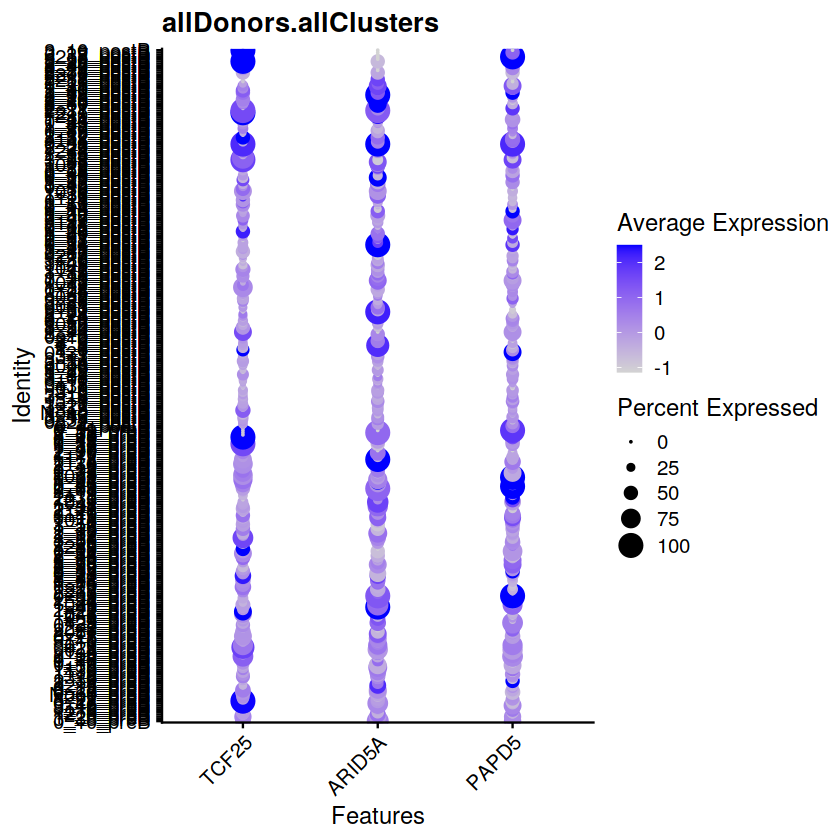

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



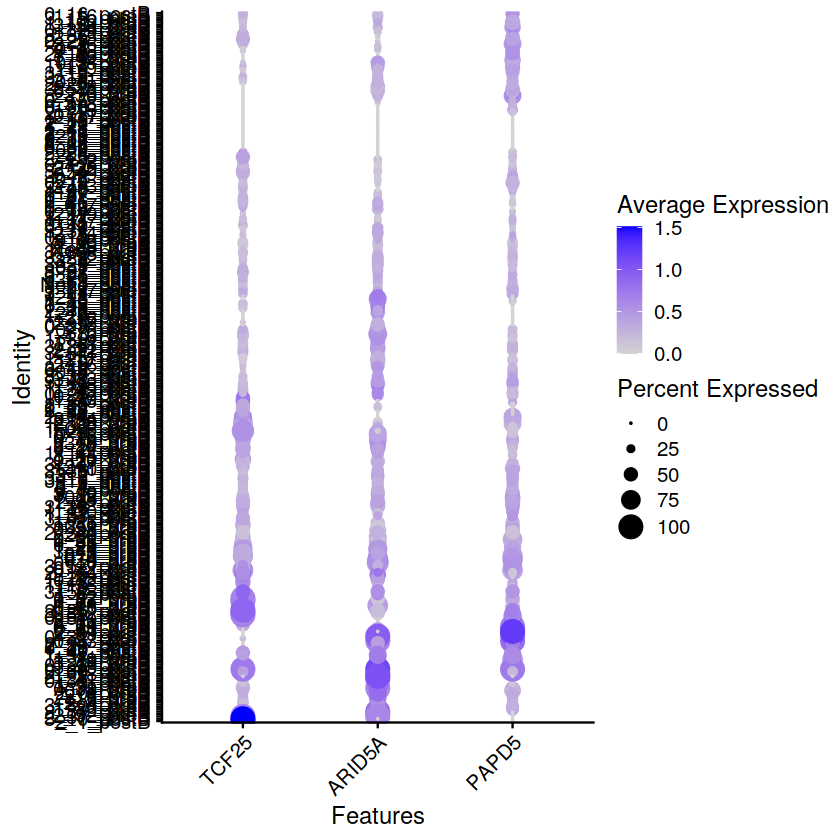

In [13]:
### a) top 3 significant results from each comparison

all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, btwnConds_inClone_sepDonors.outdir, curr.name="allDonors.allClusters", max.size=15)

dot <- DotPlot(se, scale=FALSE,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClone_sepDonors.outdir, "allDonors.allClusters.top3de.png"))
ggsave(file.path(btwnConds_inClone_sepDonors.outdir, "allDonors.allClusters.top3de.pdf"))


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



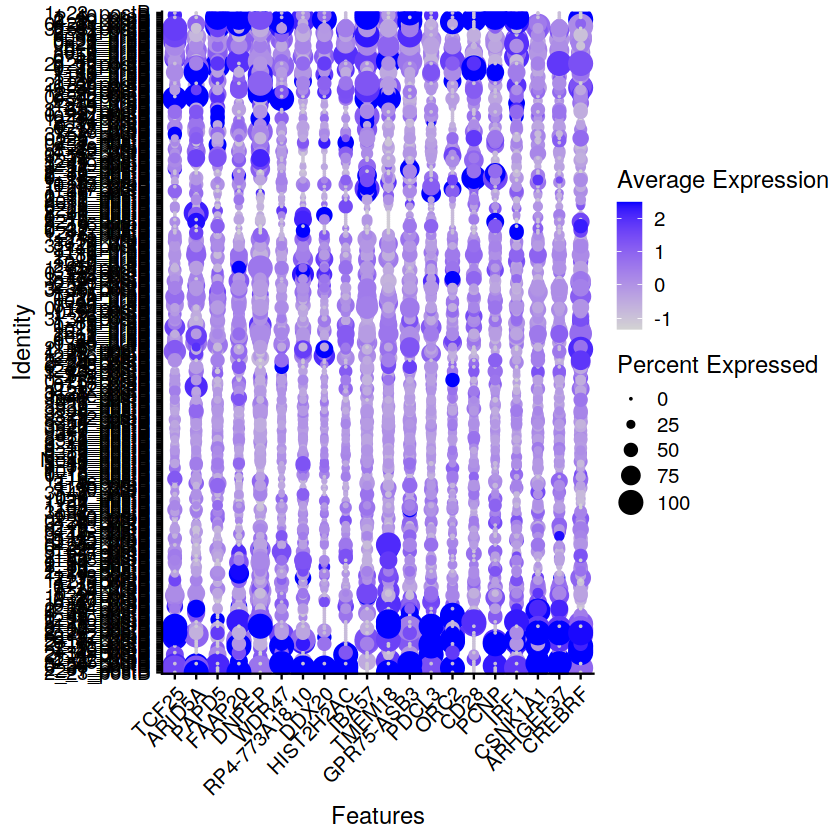

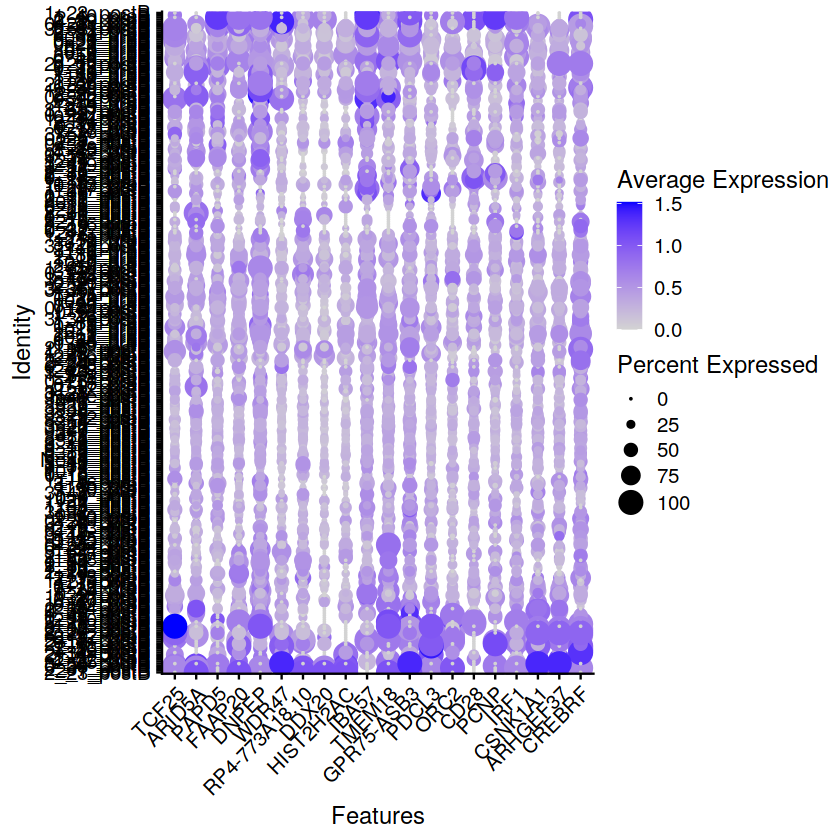

In [14]:

## b) averaged top p-values (only average ones that were DE)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClone_sepDonors.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(btwnConds_inClone_sepDonors.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot


In [15]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.1            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 

In [16]:
outdir

[1] "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/de_clone_btwncond_RNA/minPct0.01_logfc0.1_minCells10/"